# Polygons

## The Problem

Consider an n-sided polygon where n is even. We draw all the lines that connect the vertices, and mark out the intersection points. This creates a graph with the vertices and intersection points as the nodes of the graph, and the edges are the line segments between the vertices and the intersection points. You can refer to the plot below.

We define a start point and an end point as the opposite vertices of the polygon. We also define a "decreasing path" as a path along the edges of the graph that links the start point to the end point, where the distance to the end point is strictly decreasing while moving along the path. Find the total number of decreasing paths available.

## Solution Approach

1. Draw a regular polygon
2. Draw all lines between points and find the coordinates of all the intersection points
3. Draw a circle that is anchored at the endpoint, and wraps the octagon neatly; the diameter of this circle should start at L2 distance of [start point - end point]
4. Slowly reduce the circle size. It appears that points that fall out of the circle first have arrows that draw to points that fall out of the circle later

In [1]:
import numpy as np
import itertools
import operator

from math import sin, cos, pi, sqrt
from typing import List, Tuple
from matplotlib import pyplot as plt

### Create the regular polygon
Let's define some restrictions on the polygon.
1. Centred on (0,0) with radius 1 unit; thus start point is (1,0) and end point is (-1,0)
2. Use the internal angle of a polygon to find the points of the vertices

See https://en.wikipedia.org/wiki/Rotation_matrix.

Some of the code for Line and Point classes are adapted from https://stackoverflow.com/a/20679579. Also written with mathematical reference to https://observablehq.com/@toja/line-box-intersection.

In [2]:
# Rounding precision for floating point calculations
PRECISION = 13

In [3]:
class Point:
    def __init__(self, x: float, y: float):
        self.x = round(x, PRECISION) if x != None else None
        self.y = round(y, PRECISION) if y != None else None
        
    @classmethod
    def from_intersection(cls, L1:"LineSegment"=None, L2:"LineSegment"=None) -> "Point":
        '''
        Alternate constructor for Point via intersection of two LineSegments.
        '''
        D  = L1.a * L2.b - L1.b * L2.a
        Dx = L1.c * L2.b - L1.b * L2.c
        Dy = L1.a * L2.c - L1.c * L2.a
        
        if D != 0:
            x = round(Dx / D, PRECISION)
            y = round(Dy / D, PRECISION)
            
            # Disregard points outside the polygon circle
            if sqrt(x**2 + y**2) > 1:
                x, y = None, None
        else:
            x, y = None, None
        
        return cls(x, y)

    def lies_on(self, L:"LineSegment") -> bool:
        '''
        Checks that the point lies on a given line segment.
        '''
        try:
            if self.x is not None or self.y is not None:
                return self.y - L.p1.y == (-L.a)/(L.b) * (self.x - L.p1.x)
        except ZeroDivisionError:
            return self.x == L.p1.x
        return False
    
    def __eq__(self, other):
        if isinstance(other, Point):
            return self.x == other.x and self.y == other.y
        return False
    
    def __repr__(self):
        if self.x is not None and self.y is not None:
            return f"Point({round(self.x, 5)}, {round(self.y, 5)})"
        return f"Point(None, None)"
    
    def __hash__(self):
        return hash((self.x, self.y))


In [4]:
class LineSegment:
    def __init__(self, p1: "Point", p2: "Point"):
        self.p1 = p1
        self.p2 = p2
        
        # Used for Cramer's rule
        self.a = p1.y - p2.y
        self.b = p2.x - p1.x
        self.c = p1.x*p2.y - p2.x*p1.y
        
    def __repr__(self):
        return f"LineSegment({self.p1}, {self.p2})"    

In [5]:
def find_next_coordinate(xy: Tuple[float, float], t: float):
    x, y = xy
    return (x*cos(t) - y*sin(t), x*sin(t) + y*cos(t))

def create_regular_polygon(n: int) -> List[Tuple]:
    # Defines a polygon as the list of (x,y) coordinates of the vertices
    theta = 2/n * pi
    polygon = []
    start_xy = (1,0)
    
    current_xy = start_xy
    for i in range(n):
        current_xy = find_next_coordinate(current_xy, theta)
        polygon.append(current_xy)
    polygon = [Point(x,y) for x,y in polygon]
    return polygon

In [6]:
# Test the polygon creation function
create_regular_polygon(4)

[Point(0.0, 1.0), Point(-1.0, 0.0), Point(-0.0, -1.0), Point(1.0, -0.0)]

### Find the intersection points
We first create the polygon. Next, we draw a line for every pair of polygon vertices. We then find the intersection points of every pair of line segments.

In [7]:
n = 6
polygon = create_regular_polygon(n)
lines = [LineSegment(a,b) for a,b in itertools.combinations(polygon, 2)]
points = set(Point.from_intersection(a,b) for a,b in itertools.combinations(lines, 2))

In [8]:
polygon

[Point(0.5, 0.86603),
 Point(-0.5, 0.86603),
 Point(-1.0, 0.0),
 Point(-0.5, -0.86603),
 Point(0.5, -0.86603),
 Point(1.0, -0.0)]

In [9]:
lines;

In [10]:
points.remove(Point(None, None))
points;

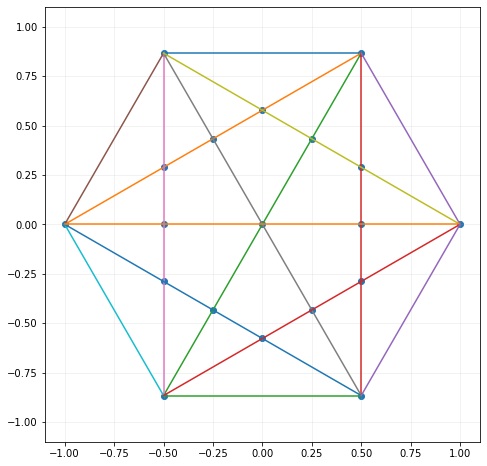

In [11]:
x = [point.x for point in points]
y = [point.y for point in points]

# Configurations
limit = 1.1
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim(-limit, limit)
ax.set_ylim(-limit, limit)
ax.set_aspect('equal', adjustable='box')
ax.grid(axis='both', alpha=0.2)

# Lines
for line in lines:
    ax.plot([line.p1.x, line.p2.x], [line.p1.y, line.p2.y])

# Points
ax.scatter(x,y) 

In [12]:
len(points)

19

In [13]:
# Add back the vertices due to rounding error
points.update(polygon)

In [14]:
points;

### Get all the line segments
Every line segment in the diagram above fulfills the following conditions:
1. Both ends of the line segment must be either an intersection point or a vertex
2. They must be an equal or shorter line deriving from one of the already drawn lines

A possible approach would be to:
1. For every line segment that we have generated, first find which points/vertices lie on it.
2. Break up the line segment into smaller line segments where possible
    - For vertex-vertex line segments with no intersection points lying on it, no smaller line segments are possible

In [15]:
# A dict[LineSegment: List] containing all the points for all line segments
line_points = {line: [point for point in points if point.lies_on(line)] for line in lines}

Assume we have a dictionary of {line: [points]}.
1. If len(points) == 2: Add the line to the final list
2. else: if the x-coord of the first two are different (not a vertical line). sort the points by x
3. else: (vertical line) we sort the points by y
4. Line segments are built by going across the list and taking a pair of points as line segments

In [16]:
line_segments = []
for ls, p in line_points.items():
    if len(p) == 2:
        line_segments.append(ls)
    else:
        sorted_points = sorted(p, key=operator.attrgetter('x','y'))
        for previous, current in zip(sorted_points, sorted_points[1:]):
            line_segments.append(LineSegment(previous, current))

In [17]:
assert len(line_segments) == n + n*(n-2)*(n-3)/2
print(len(line_segments))

42


### Label all the line segments